# NLP Final Project 1.01: Data Preparation

This notebook serves to:
- EDA on cleaned text
- Filtering with keyword-based topic match

## Set-up

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

from pprint import pprint
import re
from tqdm import tqdm
tqdm.pandas()
import numpy as np

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=12, progress_bar=True)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
#!pwd
import os

# Google Bucket
# file name checkpoint_0512_sent_split.parquet
path_bucket = 'gs://msca-sp23-bucket/nlp_data'
path_bucket_df = path_bucket + '/' + 'checkpoint_0512_sent_split.parquet'
runtime_path = '/home/anthony/projects/nlp_runtime'

os.chdir(runtime_path)
print(os.getcwd())

/home/anthony/projects/nlp_runtime


In [3]:
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

import warnings
warnings.filterwarnings("ignore")

## Data Load

In [4]:
# read data
df = pd.read_parquet('gs://msca-sp23-bucket/nlp_data/checkpoint_0523_cleaned_data.parquet', engine='pyarrow')
df.head(1)

,url,date,language,title,text_no_url,text_cleaned
0,http://en.people.cn/n3/2021/0318/c90000-9830122.html,2021-03-18,en,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,"\n\nArtificial intelligence improves parking efficiency in Chinese cities People's Daily Online\n\nHome\nChina Politics\nForeign Affairs\nOpinions\nVideo: We Are China\nBusiness\nMilitary\nWorld\nSociety\nCulture\nTravel\nScience\nSports\nPhoto\n\nLanguages\n\nChinese\nJapanese\nFrench\nSpanish\nRussian\nArabic\nKorean\nGerman\nPortuguese\nThursday, March 18, 2021\nHome \n \nArtificial intelligence improves parking efficiency in Chinese cities\nBy Liu Shiyao People's Daily 09:16, March ...","Artificial intelligence improves parking efficiency in Chinese cities People's Daily Online Chinese Japanese French Spanish Russian Arabic Korean German Portuguese Thursday, March 18, 2021 Home Artificial intelligence improves parking efficiency in Chinese cities By Liu Shiyao People's Daily 09:16, March 18, 2021 Photo taken on July 1, 2019, shows a sign for electronic toll collection ETC newly set up at a roadside parking space on Yangzhuang road, Shijingshan district, Beijing. So..."


In [5]:
df.shape

(200332, 6)

## Primary Filtering: Select Relevant Titles & Text

In [6]:
# use all titles to make a word cloud
df_title = df[['title']]
df_title.head()

,title
0,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online
1,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament
2,"Forget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & Rework Solutions - Dataweek"
3,Strategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered – Consumer Electronics Net
4,Olympus to Support Endoscopic AI Diagnosis Education for Doctors in India and to Launch AI Diagnostic Support Application | | IT Business Net


### WordCloud on topics

In [7]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#% matplotlib inline

In [8]:
# remove punctuations in title
df_title['title'] = df_title['title'].str.replace('[^\w\s]','')

# only keep alphabets
df_title['title'] = df_title['title'].str.replace('[^a-zA-Z]',' ')

In [9]:
text = " ".join(title for title in df.title)
print ("There are {} words in the combination of all review.".format(len(text)))

There are 20190116 words in the combination of all review.


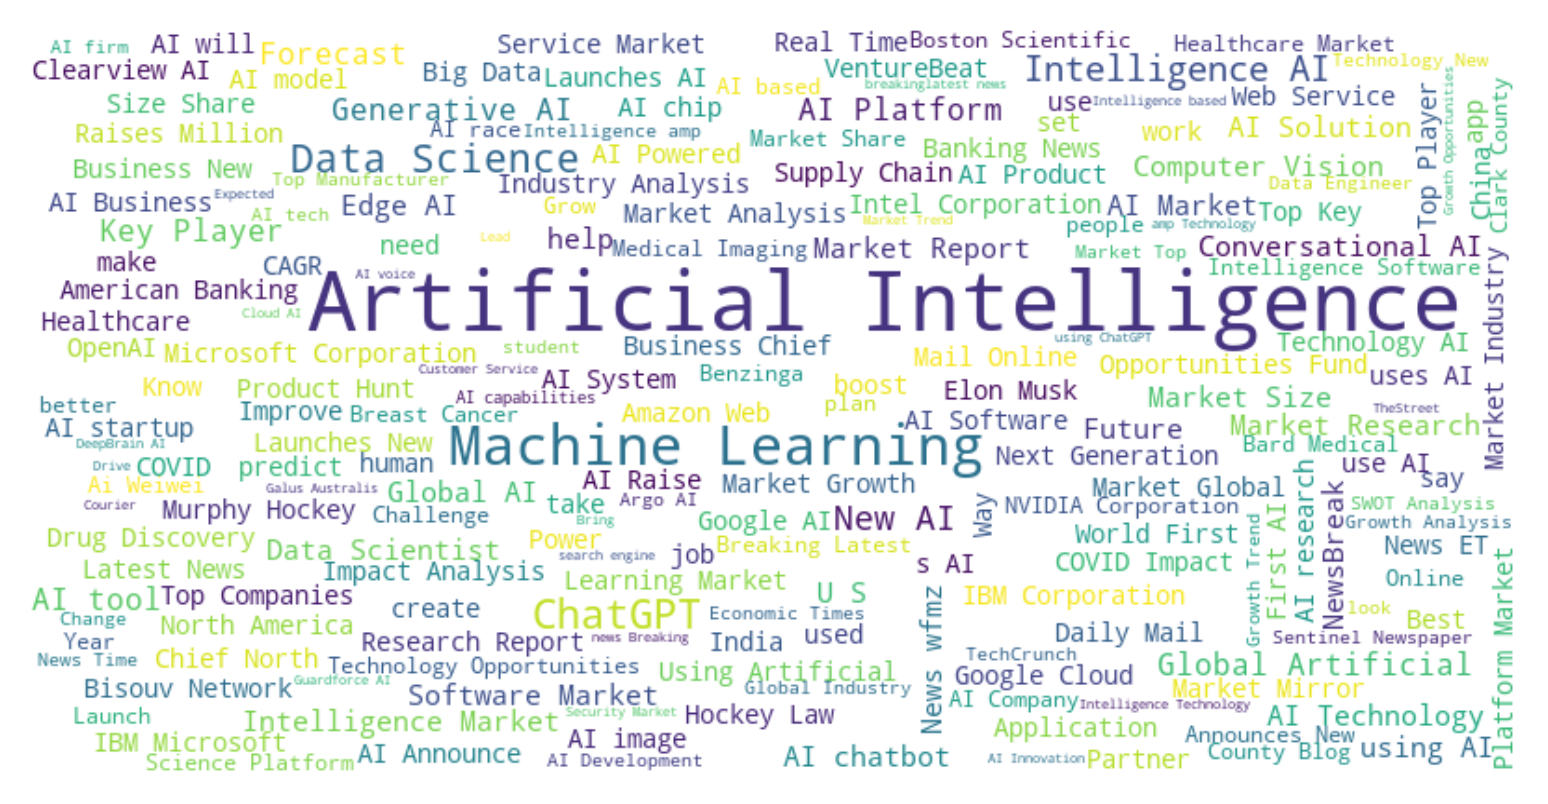

In [41]:
# ref: https://www.datacamp.com/tutorial/wordcloud-python

# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["drink", "now", "wine", "flavor", "flavors"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate(text)

# Display the generated image:
# the matplotlib way (set dpi=100)
plt.figure(dpi=300)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [15]:
# Create a WordCloud object
wc = WordCloud(stopwords=stopwords, background_color="white")

# Generate the word frequencies from the text
word_frequencies = wc.process_text(text)

# Convert the word frequencies to a list of tuples
word_list = list(word_frequencies.items())

# Sort the word list by frequency
sorted_word_list = sorted(word_list, key=lambda x: x[1], reverse=True)

In [16]:
# check
print(len(sorted_word_list))
sorted_word_list[:10]

83936


[('Artificial Intelligence', 37129),
 ('Machine Learning', 12146),
 ('ChatGPT', 5696),
 ('Data Science', 5177),
 ('Intelligence AI', 4136),
 ('New AI', 3676),
 ('Key Player', 2930),
 ('Forecast', 2849),
 ('Generative AI', 2779),
 ('AI Platform', 2770)]

In [17]:
# visualze the top 100 words and frequencies using a horizontal barplot
import seaborn as sns

# create a dataframe
df_word = pd.DataFrame(sorted_word_list[:100], columns=['word', 'freq'])
df_word.head()

,word,freq
0,Artificial Intelligence,37129
1,Machine Learning,12146
2,ChatGPT,5696
3,Data Science,5177
4,Intelligence AI,4136


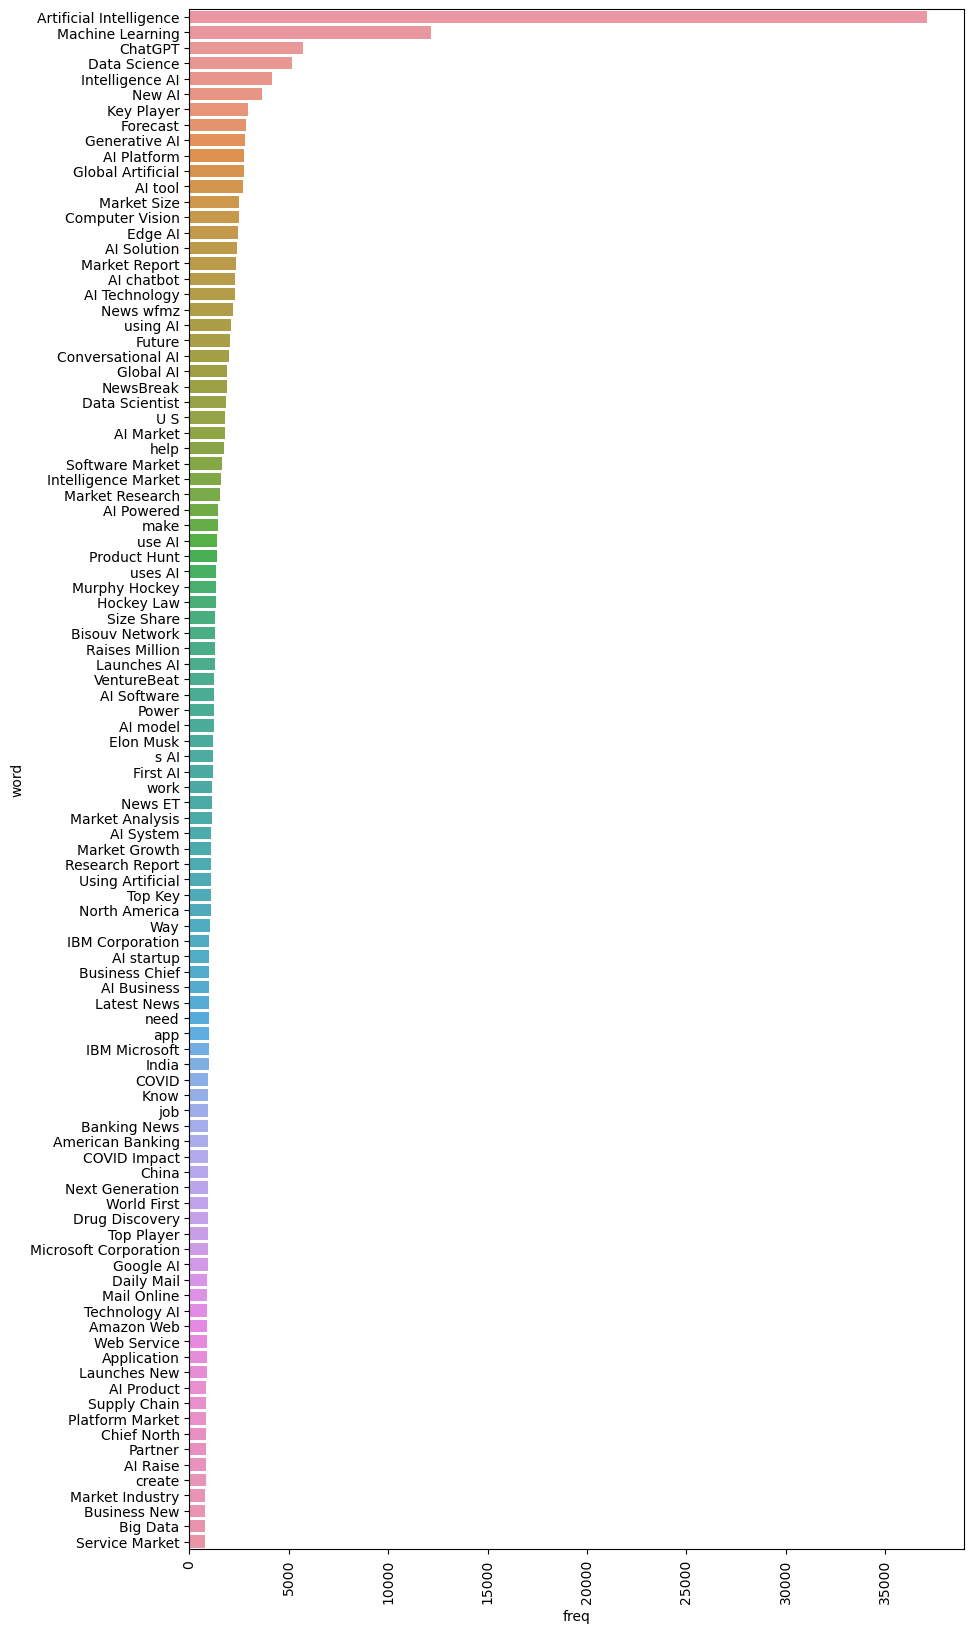

In [18]:
# plot
plt.figure(figsize=(10, 20))
sns.barplot(x='freq', y='word', data=df_word)
plt.xticks(rotation=90)
plt.show()

In [19]:
#df_word[df_word['word'] == 'Conversational AI']

,word,freq
22,Conversational AI,1970


### Filtering articles using title and text

In [20]:
# collect the top 22 words in the df_word; in lower cases
wc_keywords = df_word['word'].str.lower().tolist()[:15]
user_keywords = ['Big Data', 'Data Mining', 'Data Visualization', 'Data Science', 
                 'Data Warehousing', 'Business Intelligence', 'Business Analytics', 'Predictive Analytics', 'Statistical Modeling', 'Machine Learning', 'Deep Learning', 'Neural Networks', 'Convolutional Neural Networks', 
                 'Recurrent Neural Networks', 'Generative Adversarial Networks', 'Natural Language Processing', 'Computer Vision', 'Image Processing', 
                 'Speech Recognition', 'Chatbots', 'Conversational AI', 'Autonomous Driving', 'Autonomous Car', 'Robotics', 'Reinforcement Learning', 'Transfer Learning', 'Model Deployment', 
                 'Model Monitoring', 'Model Interpretability', 'A/B Testing', 'healthcare',
                 'MLOps', 'CI/CD', 'Cloud Computing', 'Edge Computing', 'IoT', 'Blockchain', 'Privacy-Preserving Machine Learning', 'Federated Learning', 'Differential Privacy', 
                 'Sentiment Analysis', 'Speech-to-Text', 'Text-to-Speech', 'OCR', 'Object Detection', 'Semantic Segmentation', 'Recommendation Systems']

# convert to lower cases
user_keywords = [x.lower() for x in user_keywords]

# combine the two lists and convert to lower cases
filter_keywords = wc_keywords + user_keywords

In [21]:
# save filter keywords
with open('word_list.txt', 'w') as f:
    for word in filter_keywords:
        f.write(word + '\n')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200332 entries, 0 to 200331
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   url           200332 non-null  object
 1   date          200332 non-null  object
 2   language      200332 non-null  object
 3   title         200332 non-null  object
 4   text_no_url   200332 non-null  object
 5   text_cleaned  200332 non-null  object
dtypes: object(6)
memory usage: 9.2+ MB


In [25]:
# change 'text_rejoined' and 'title' to str
df['text_cleaned'] = df['text_cleaned'].astype(str)
df['title'] = df['title'].astype(str)

In [27]:
# with title and text_rejoined, using parallel processing and ignore case; only keep those rows that contain at least one keyword
'''#df_test = df.sample(1000)
df_selected = df[df['title'].str.contains('|'.join(filter_keywords), case=False) |
                      df['text_rejoined'].str.contains('|'.join(filter_keywords), case=False)]'''

# Using pandaraellel for faster processing
# Define the filtering function
def filter_rows(row, filter_keywords):
    for keyword in filter_keywords:
        if keyword.lower() in row['title'].lower() or keyword.lower() in row['text_cleaned'].lower():
            return True
    return False

# Apply the function in parallel
#df_test = df.sample(30)
df_selected = df[df.parallel_apply(filter_rows, args=(filter_keywords,), axis=1)]

In [31]:
# check the shape
print('initial no.of articles', len(df))
print('filtered no.of articles', len(df_selected))

initial no.of articles 200332
filtered no.of articles 185479


In [30]:
# drop unnecessary columns
df_selected = df_selected.drop(columns=['language', 'text_no_url'])

In [39]:
df_selected.sample(5)

,url,date,title,text_cleaned
126830,https://www.keyc.com/prnewswire/2022/04/18/sas-data-ethics-head-named-national-ai-advisory-committee/,2022-04-18,SAS data ethics head named to National AI Advisory Committee,"SAS data ethics head named to National AI Advisory Committee Skip to contentYour CalendarWhat's On CBS, FOX, NBC, CWOur ContestsAbout UsAbout KEYC GuideWatch PhotosWatch LiveSend Us A News TipNewsKEYC News Now This Road ConditionsIowa Road ConditionsMap RoomWeather ExtraMaverick Hockey Quick HitsPrep Athlete of the WeekPrep Athlete of the Week CalendarGood Morning GivebackGolden AppleGolden Apple NominationsPick of the LitterSomeone You Should KnowMr. ScheduleAbout UsContact UsMee..."
27419,https://clarkscarlet.com/news/287720/artificial-intelligence-in-medical-diagnostics-market-opportunity-demand-recent-trends-major-driving-factors-and-business-growth-strategies-2025/,2020-09-06,"Artificial Intelligence in Medical Diagnostics Market Opportunity, Demand, recent trends, Major Driving Factors and Business Growth Strategies 2025 – The Scarlet","Artificial Intelligence in Medical Diagnostics Market Opportunity, Demand, recent trends, Major Driving Factors and Business Growth Strategies 2025 The Scarlet The Scarlet Space, Science and Energy Market Energy News Coronavirus Space Contact Intelligence in Medical Diagnostics Market Opportunity, Demand, recent trends, Major Driving Factors and Business Growth Strategies 2025 Artificial Intelligence in Medical Diagnostics Market Opportunity, Demand, recent tren..."
67089,https://www.jpost.com/cybertech/ai-helps-british-research-center-use-machine-learning-to-fight-covid-19-634506,2020-07-09,AI helps British research center use machine learning to fight COVID-19 - The Jerusalem Post,"AI helps British research center use machine learning to fight COVID 19 The Jerusalem Post Coronavirus AI helps British research center use machine learning to fight COVID 19 Using the pany's technology, the center can now conduct more experiments, utilize resources more efficiently, and speed pletion of data science models By CYBERTECH JULY 9, 2020 17:53 Artificial intelligence photo credit: INGIMAGE Advertisement Data science startup Run:AI announced July 8 that i..."
168433,https://www.thehour.com/news/article/it-takes-a-body-to-understand-the-world-why-17881946.php,2023-04-06,It takes a body to understand the world – why ChatGPT and other language AIs don't know what they're saying,It takes a body to understand the world why ChatGPT and other language AIs don't know what they're saying Currently Reading It takes a body to understand the world why ChatGPT and other language AIs don't know what they're saying UsManage With UsAdvertise With Of UseDigital you SEEN? SchoolHigh School WorkplacesReal and GardenFoodBest OfEducationHome ServicesLegal ServicesSenior 's PaperInsider mended Mixed use development proposed in SoNo to face public hearing Stew L...
42492,https://www.wthr.com/article/news/nation-world/elon-musk-truthgpt-to-counter-ai-bias/507-e69b0f02-c69f-4f67-882f-02bd5249649c,2023-04-18,Elon Musk says he'll create ChatGPT alternative to counter bias | wthr.com,"Elon Musk says he'll create ChatGPT alternative to counter bias Skip Navigation Share on Facebook Features Latest News Stories Threat leads to lockdown, evacuation of Alexandria Monroe Junior/Senior High School 2 staff members at Brownsburg elementary school face termination, 3 more on leave after alleged 'mistreatment' of special education student Weather Back Traffic Latest Weather Stories Cold night, frost and freeze possible April 17, 2023 Monday evening Live Doppler 13 forecast..."


In [40]:
# save a copy at bucket
bucket_write = path_bucket + '/' + 'checkpoint_0523_cleaned_filtered_data.parquet'
df_selected.to_parquet(bucket_write, index=False)